In [4]:
import tensorflow as tf
# from tensorflow import keras
from keras import layers
# from keras.applications import MobileNetV3Small, MobileNetV3Large
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
import matplotlib.pyplot as plt

StatementMeta(, fe7ca058-37e2-42d9-98ce-7b171cb5c5c0, 6, Finished, Available)

In [5]:
def plot_history(history):
  f = plt.figure()
  f.set_figwidth(13)
  #  "Accuracy"
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  # "Loss"
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

StatementMeta(, fe7ca058-37e2-42d9-98ce-7b171cb5c5c0, 7, Finished, Available)

In [6]:
# Load the dataset of labeled images
batch_size = 20
img_height = 224
img_width = 224

# PLEASE CHANGE THIS PATH ACCORDING TO YOUR ACTUAL DATA PATH
data_path = "/lakehouse/default/Files/archive"

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_path,
  label_mode='int',
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_path,
  label_mode='int',
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

StatementMeta(, fe7ca058-37e2-42d9-98ce-7b171cb5c5c0, 8, Finished, Available)

Found 2378 files belonging to 4 classes.
Using 1903 files for training.
Found 2378 files belonging to 4 classes.
Using 475 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

StatementMeta(, fe7ca058-37e2-42d9-98ce-7b171cb5c5c0, 9, Finished, Available)

['BIRAD1', 'Birad3', 'Birad4', 'Birad5']


In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  print(labels_batch)
  break

StatementMeta(, fe7ca058-37e2-42d9-98ce-7b171cb5c5c0, 10, Finished, Available)

2024-03-11 11:57:47.565558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1903]
	 [[{{node Placeholder/_4}}]]
2024-03-11 11:57:47.565883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1903]
	 [[{{node Placeholder/_0}}]]


(20, 224, 224, 3)
(20,)
tf.Tensor([0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0], shape=(20,), dtype=int32)


StatementMeta(, fe7ca058-37e2-42d9-98ce-7b171cb5c5c0, 11, Finished, Available)

2024-03-11 11:57:50.667261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1903]
	 [[{{node Placeholder/_0}}]]
2024-03-11 11:57:50.667561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1903]
	 [[{{node Placeholder/_0}}]]


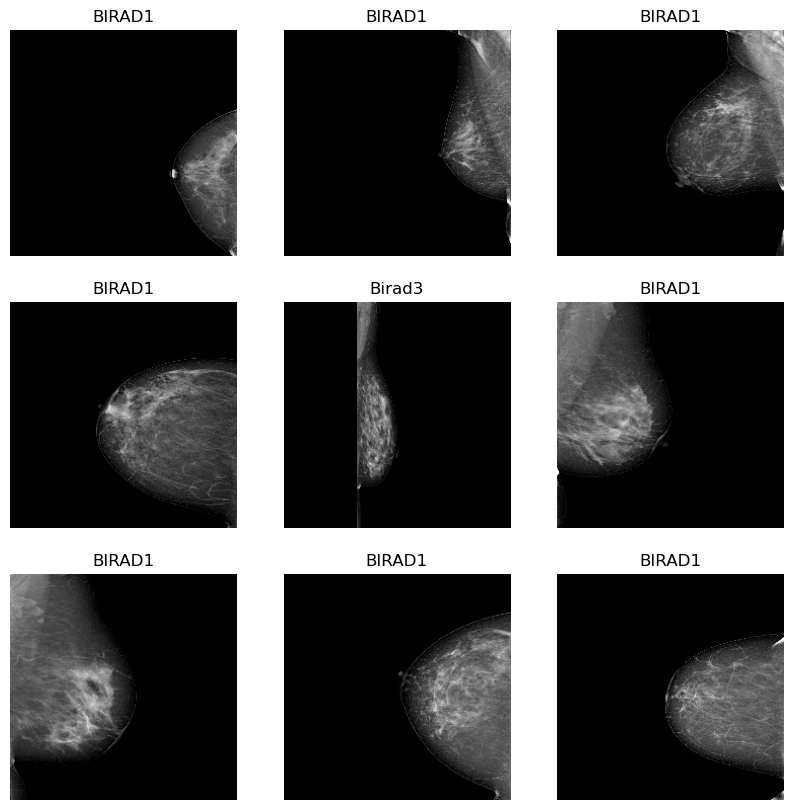

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
# USE PRE-TRAINED DATA AND REGU (DROPOUT +L2)

input_shape = (224, 224, 3)
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)

for layer in vgg16.layers:
  layer.trainable = False

penalty = 0.01

model = Sequential()
model.add(vgg16)
model.add(layers.Flatten())
model.add(layers.Dense(4096, kernel_regularizer=l2(penalty)))
model.add(layers.Dropout(rate=0.25))
model.add(layers.Dense(4096, kernel_regularizer=l2(penalty)))
model.add(layers.Dropout(rate=0.25))
model.add(layers.Dense(4, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.00003),
              metrics=["accuracy"])

checkpoint = ModelCheckpoint(
                             filepath='vgg16_bi_rads.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True)

history = model.fit(train_ds, validation_data=val_ds, epochs=5)

# Save the trained model
model.save("/lakehouse/default/Files/archive/vgg16_bi_rads.h5")

StatementMeta(, fe7ca058-37e2-42d9-98ce-7b171cb5c5c0, 12, Finished, Available)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/5
96/96 [==============================] - 202s 2s/step - loss: 114.2492 - accuracy: 0.7735 - val_loss: 112.9940 - val_accuracy: 0.8105
Epoch 2/5
96/96 [==============================] - 202s 2s/step - loss: 113.2556 - accuracy: 0.8171 - val_loss: 113.1726 - val_accuracy: 0.8042
Epoch 3/5
96/96 [==============================] - 206s 2s/step - loss: 112.9636 - accuracy: 0.8282 - val_loss: 112.7955 - val_accuracy: 0.8000
Epoch 4/5
96/96 [==============================] - 204s 2s/step - loss: 112.8707 - accuracy: 0.8360 - val_loss: 112.8106 - val_accuracy: 0.8021
Epoch 5/5
96/96 [==============================] - 201s 2s/step - loss: 112.6980 - accuracy: 0.8492 - val_loss: 112.5683 - val_accuracy: 0.8000

2024-03-11 12:00:37.067690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [475]
	 [[{{node Placeholder/_4}}]]
2024-03-11 12:00:37.067977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [475]
	 [[{{node Placeholder/_4}}]]


StatementMeta(, fe7ca058-37e2-42d9-98ce-7b171cb5c5c0, 13, Finished, Available)

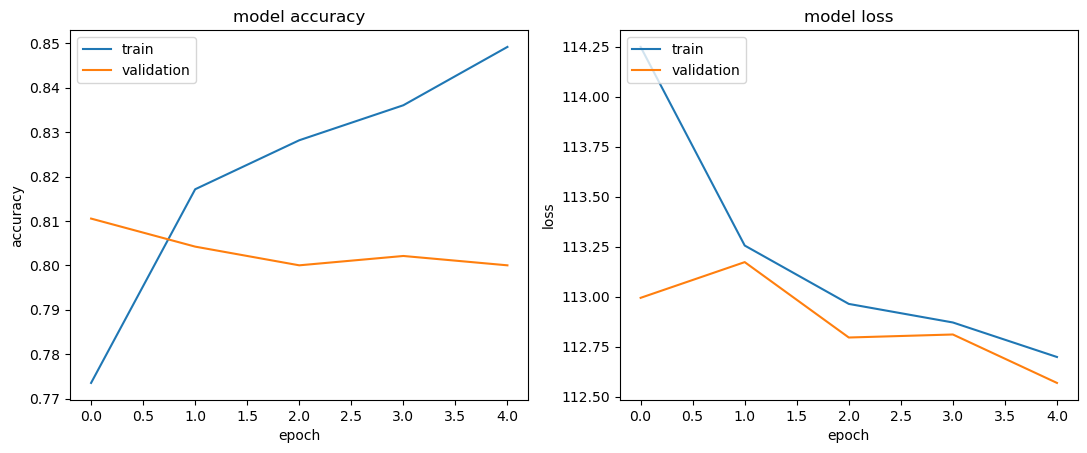

In [11]:
plot_history(history)

In [1]:
import numpy as np
from keras.models import load_model
from keras import utils

IMG_HEIGHT = 224
IMG_WIDTH = 224

loaded_model = None

def get_model():
    global loaded_model
    if loaded_model is None:
        # use path from "Copy File API path" option
        loaded_model = load_model("/lakehouse/default/Files/archive/test_mode.h5")
    return loaded_model

# prediction function using the model loaded from .h5 file
def predict_with_loaded_model(image_path):
    img = utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    model = get_model()
    prediction = model.predict(img_array)
    prediction_array = prediction[0]
    labels = ['BIRAD1', 'BIRAD3', 'BIRAD4', 'BIRAD5']
    result_dict = dict(zip(labels, prediction_array))
        
    return result_dict

StatementMeta(, 8e902250-e2b0-4b75-b166-f572075bd93b, 3, Finished, Available)

2024-03-11 13:36:46.485647: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-11 13:36:50.475456: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
prediction = predict_with_loaded_model("/lakehouse/default/Files/archive/Birad5/2016_BC016741_ MLO_L.jpg")
prediction

StatementMeta(, 8e902250-e2b0-4b75-b166-f572075bd93b, 4, Finished, Available)

1/1 [==============================] - 1s 1s/step


{'BIRAD1': 2.0046051e-09,
 'BIRAD3': 1.0321614e-14,
 'BIRAD4': 1.7698373e-17,
 'BIRAD5': 1.0}

In [5]:
import tensorflow as tf
tf.__version__

StatementMeta(, 64a6e4e2-1a65-4888-aa0c-3e035ccc83f3, 7, Finished, Available)

'2.12.1'

In [7]:
import keras
keras.__version__

StatementMeta(, 64a6e4e2-1a65-4888-aa0c-3e035ccc83f3, 9, Finished, Available)

'2.12.0'

In [8]:
!pip3 freeze

StatementMeta(, 64a6e4e2-1a65-4888-aa0c-3e035ccc83f3, 10, Finished, Available)

absl-py @ file:///home/conda/feedstock_root/build_artifacts/absl-py_1695154477682/work
adal @ file:///home/conda/feedstock_root/build_artifacts/adal_1617781612176/work
adlfs @ file:///home/conda/feedstock_root/build_artifacts/adlfs_1682630152363/work
aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1696765415812/work
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1667935791922/work
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1694690212886/work
ansi2html @ file:///home/conda/feedstock_root/build_artifacts/ansi2html_1695768997499/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1688651106312/work/dist
appdirs @ file:///home/conda/feedstock_root/build_artifacts/appdirs_1603108395799/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1692818318753/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1695386546427/work
arrow @ fi